In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from scMultiSim import generate_data
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, auc, precision_recall_curve
from bicycle.utils.mask_utils import get_mask2, get_sparsity, add_saltpepper, normalize_matrix, above_threshold, add_noise
from sklearn.decomposition import PCA
from scipy.special import expit

/data/toulouse/miniforge3/envs/scm_compile/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
save = True

In [3]:
def get_precision(grn, beta):
    grn=grn.flatten()
    beta=beta.flatten()
    # normalize to [0, 1]
    grn = (grn > 0.001).astype(int)
    #beta[beta<0] = 0
    beta = expit(beta)
    average_precision = average_precision_score(grn, beta)
    return average_precision
def get_auprc(grn, beta):
    grn=grn.flatten()
    beta=beta.flatten()
    # normalize to [0, 1]
    grn = (grn > 0).astype(int)
    #beta[beta<0] = 0
    beta = expit(beta)
    p,r,t = precision_recall_curve(grn, beta)
    auprc = auc(r,p)
    return auprc
def apply_pca(data_profile:dict, n_comp=None, mask=[]):
    new_profile = data_profile.copy()
    atac = new_profile["atac"]
    pca = PCA(svd_solver="full").fit(atac)
    atac=pca.transform(atac)
    if len(mask) >0:
        atac[:,mask] = 0
    if n_comp!= None:
        atac[:, n_comp:] = 0
    #print(np.min(atac, axis=None))
    #atac = atac + np.abs(np.min(atac, axis=None))
    atac = pca.inverse_transform(atac)
    new_profile["atac"]= atac
    return new_profile
'''def get_mask2(atac,
             region_to_gene,
             region_to_tf,
             threshold = False,
             percentile : int = 50,
             correlation = False,
             corr_normalize = False,
             corr_threshold = False,
             corr_threshold_percentile: int = 50,
             pseudocounts = False,
             ):
    """
    Args:
    atac (np.array): regions x samples
    params (dict): function parameters
    """
    if pseudocounts:
        atac += np.min(atac)*0.0001
    if correlation and atac.shape[1]>1:
        corr_atac = np.abs(np.corrcoef(atac))
        #plt.imshow(corr_atac)
        if corr_normalize:
#            print("norm")
            corr_atac = normalize_matrix(corr_atac)
        if corr_threshold:
#            print("threshold")
            corr_atac = above_threshold(corr_atac, corr_threshold_percentile)
    else:
        corr_atac = atac @ atac.T
    mask = region_to_gene.T @ corr_atac @ region_to_tf
    if threshold:
        mask = above_threshold(mask, percentile)
    return mask'''

def output_precision(mask_output):
    return mask_output[0]
def selection_wrap(
    mask_threshold,
    mask_percentile,
    mask_correlation,
    mask_corr_normalize,
    mask_corr_threshold,
    mask_corr_threshold_percentile,
    mask_pseudocounts,
    **config
    ):
    mask_kwargs={
        "threshold":mask_threshold,
        "percentile":mask_percentile,
        "correlation":mask_correlation,
        "corr_normalize":mask_corr_normalize,
        "corr_threshold":mask_corr_threshold,
        "corr_threshold_percentile":mask_corr_threshold_percentile,
        "pseudocounts":mask_pseudocounts,}
    return generate_data(**config, mask_kwargs=mask_kwargs)

def selection_wrap_pca(**input):
    atac = input.pop("atac")
    region_to_tf = input.pop("region_to_tf")
    region_to_gene = input.pop("region_to_gene")
    return get_mask2(atac=atac,
                     region_to_gene=region_to_gene,
                     region_to_tf=region_to_tf,
                     pca=True,
                     pcs = list(input.values()))

In [4]:
# Forward selection
def for_select(data,
               _parameters,
               _baseline_prec = 0,
               eval = get_precision,
               mask_func = get_mask2,
               eval_kwargs = {},):
    if _baseline_prec == 0:
        mask_output = mask_func(**_parameters, **data)
        _baseline_prec = eval(mask_output, **eval_kwargs)
        #print(_baseline_prec)

    precisions = []
    for key, value in _parameters.items():

        if value:
            precisions.append(0)
            continue
        if not type(value) is bool:
            precisions.append(0)
            continue
        params = _parameters.copy()
        params[key] = True
        mask_output = mask_func(**params, **data)
        precisions.append(eval(mask_output, **eval_kwargs))
    
    #print(precisions)
    #print(_parameters)
    max_prec = np.max(precisions)
    
    if max_prec < _baseline_prec:
        return _parameters, _baseline_prec
    
    argmax = np.argmax(precisions)
    maxkey = [n for n in _parameters.keys()][argmax]
    _parameters[maxkey] = True

    return for_select(data, _parameters, max_prec, eval=eval, mask_func=mask_func)

# Reverse selection
def rev_select(data,
               _parameters,
               _baseline_prec = 0,
               eval = get_precision,
               mask_func = get_mask2,
               eval_kwargs = {},):
    if _baseline_prec == 0:
        mask_output = mask_func(**_parameters,**data)
        _baseline_prec = eval(mask_output, **eval_kwargs)
        #print(_baseline_prec)
    precisions = []
    keys = []
    for key, value in _parameters.items():

        if not value:
            continue
        if not type(value) is bool:
            continue
        params = _parameters.copy()
        params[key] = False
        mask_output = mask_func(**data, **params)
        precisions.append(eval(mask_output, **eval_kwargs))
        keys.append(key)
    #print(f"precisions: {precisions}")
    #print(f"keys: {keys}")
    if len(precisions) ==0:
        #max_prec = eval(grn,mask_func(**data, **_parameters))
        return _parameters, _baseline_prec
    
    max_prec = np.max(precisions)
    
    if max_prec < _baseline_prec:
        return _parameters, _baseline_prec
    
    argmax = np.argmax(precisions)
    maxkey = keys[argmax]
    _parameters[maxkey] = False
    return rev_select(data,
                      _parameters,
                      max_prec,
                      eval=eval,
                      mask_func=mask_func)


In [12]:
config = {
    "n_genes":10,
    "grn_params":{},
    "n_samples_control": 500,
    "n_samples_per_pert": 0,
    "train_gene_ko": [],
    "test_gene_ko": [],
    "pert_type":"dCas9",
    "pert_strength":0,
    "add_noise":False,
    "add_batch": False,
    "cache_path": Path("./scMultiSim_cache/"),
    "scMultiSim": Path("./scMS.R"),
    "create_mask":True,
    "normalize":True,
    "pseudocounts":  True,
    "generate_graph":  True,
    "verbose": False,
    "sem" :"pert_grn",
}

threshold = 80

rev_parameters = {
    "threshold" : True,
    "percentile" : threshold,
    "correlation" : True,
    "corr_normalize" : True,
    "corr_threshold" : True,
    "corr_threshold_percentile" : threshold,
    "pseudocounts" : True,
    }

for_parameters = {
    "threshold" : False,
    "percentile" : threshold,
    "correlation" : False,
    "corr_normalize" : False,
    "corr_threshold" : False,
    "corr_threshold_percentile" : threshold,
    "pseudocounts" : False,
    }
print(threshold)


80


In [13]:
# increase noise on the region matrices
repeats = 5
step = 0.1
max = 1.1
rev_results = np.empty((int(max/step), len(rev_parameters.values()), repeats))
for_results = np.empty((int(max/step), len(for_parameters.values()), repeats))
for r in range(repeats):
    print(f"r: {r}")
    for n, p in enumerate(np.arange(0,max, step)):
        print(f"p: {p}")
        config.update({"noise_p":p})
        data, mask, full_rna, gt_interv, sim_regime, beta = generate_data(
            **config)
        
        grn = data.pop("geff")
        base_prec = get_precision(grn, get_mask2(**data, **rev_parameters))
        params, max_prec= rev_select(data=data.copy(),
                                     _parameters=rev_parameters.copy(),
                                     eval=lambda x:get_precision(grn=grn,
                                                                 beta=x)
                                    )
        
        del params["percentile"]
        del params["corr_threshold_percentile"]
        
        rev_results[n,:, r] = np.append([max_prec, base_prec],
                                        list(params.values()))
        

        data, mask, full_rna, gt_interv, sim_regime, beta = generate_data(
            **config)
        grn = data.pop("geff")
        base_prec = get_precision(grn, get_mask2(**data, **for_parameters))
        params, max_prec= for_select(data=data.copy(),
                                     _parameters=for_parameters.copy(),
                                     eval=lambda x:get_precision(grn=grn,
                                                                 beta=x)
                                    )
        
        del params["percentile"]
        del params["corr_threshold_percentile"]
        #print(max_prec)
        #print(base_prec)
        for_results[n,:, r] = np.append([max_prec, base_prec],
                                        list(params.values()))

r: 0
p: 0.0
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.0
average precision vs geff:  0.15214141414141413
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.15897354497354496
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.0
average precision vs geff:  0.1628977272727273
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.1678670634920635
Trimming RNA.
p: 0.1
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.1
average precision vs geff:  0.24579381767408182
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.2527178470988247
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.1
average precision vs geff:  0.2303038603313852
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.24239448151681067
Trimming RNA.
p: 0.2
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.2
average precision vs geff:  0.1835097919965803
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.18757895690994042
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.2
average precision vs geff:  0.1281608930042324
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.12997632853226154
Trimming RNA.
p: 0.30000000000000004
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.30000000000000004
average precision vs geff:  0.19249381877033833
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.20218056389633765
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.30000000000000004
average precision vs geff:  0.20905984114392315
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.23288723111273713
Trimming RNA.
p: 0.4
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.4
average precision vs geff:  0.2556657195027118
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.2556657195027118
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.4
average precision vs geff:  0.22485217861198187
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.23726309964920056
Trimming RNA.
p: 0.5
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.5
average precision vs geff:  0.3156898128010724
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.3259681088403768
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.5
average precision vs geff:  0.2586101493066693
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.29387940883677965
Trimming RNA.
p: 0.6000000000000001
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.6000000000000001
average precision vs geff:  0.17910981495311265
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.18719768056831299
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.6000000000000001
average precision vs geff:  0.21838385695077028
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.2451708683549657
Trimming RNA.
p: 0.7000000000000001
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.7000000000000001
average precision vs geff:  0.20066940696584643
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.20765172614926333
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.7000000000000001
average precision vs geff:  0.18107641878078357
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.1886789809111491
Trimming RNA.
p: 0.8
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.8
average precision vs geff:  0.20818175752375656
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.24410953572387808
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.8
average precision vs geff:  0.25973079587254966
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.27447216012741493
Trimming RNA.
p: 0.9
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.9
average precision vs geff:  0.3269639006493881
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.32868507508390093
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.02 mins
0
Normalizing data
Normalizing data
Adding noise: 0.9
average precision vs geff:  0.12702045960223562
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.13459179297050874
Trimming RNA.
p: 1.0
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 1.0
average precision vs geff:  0.17651134517814698
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.19922200483258598
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 1.0
average precision vs geff:  0.19986939924469568
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.2053246837149836
Trimming RNA.
r: 1
p: 0.0
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.0
average precision vs geff:  0.237709595959596
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.24625000000000002
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.0
average precision vs geff:  0.13720142602495544
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.14626750700280114
Trimming RNA.
p: 0.1
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.1
average precision vs geff:  0.14829191663252103
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.15849092265651885
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.1
average precision vs geff:  0.18819685137319828
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.19306632140912044
Trimming RNA.
p: 0.2
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.2
average precision vs geff:  0.17677620707587732
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.2455372390057408
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.2
average precision vs geff:  0.2241623107013919
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.2241623107013919
Trimming RNA.
p: 0.30000000000000004
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.30000000000000004
average precision vs geff:  0.21198682193804744
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.2185950761557669
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.30000000000000004
average precision vs geff:  0.1590697035917863
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.1678431005267587
Trimming RNA.
p: 0.4
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.4
average precision vs geff:  0.24645298599168922
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.2859943068938036
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.4
average precision vs geff:  0.17024329977497094
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.20386518755304092
Trimming RNA.
p: 0.5
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.5
average precision vs geff:  0.2496046146633495
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.25947799349359785
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.5
average precision vs geff:  0.22515137124698673
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.22957602800671265
Trimming RNA.
p: 0.6000000000000001
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.6000000000000001
average precision vs geff:  0.13834310301874075
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.16169538463492183
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.6000000000000001
average precision vs geff:  0.20448309428672568
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.21546165281441343
Trimming RNA.
p: 0.7000000000000001
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.7000000000000001
average precision vs geff:  0.1389227664557305
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.1545494257420823
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.7000000000000001
average precision vs geff:  0.3387880440588996
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.3731810970742899
Trimming RNA.
p: 0.8
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.8
average precision vs geff:  0.23627062169407578
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.29591276259440435
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.8
average precision vs geff:  0.15197373160984035
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.16873741877561452
Trimming RNA.
p: 0.9
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.9
average precision vs geff:  0.17078750242944318
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.18231044759976744
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.9
average precision vs geff:  0.3470264022588856
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.35496624309147606
Trimming RNA.
p: 1.0
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 1.0
average precision vs geff:  0.17673761187458858
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.19028818102379616
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 1.0
average precision vs geff:  0.13216305427142278
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.15036513798278028
Trimming RNA.
r: 2
p: 0.0
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.0
average precision vs geff:  0.23524891774891776
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.24210884353741494
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.0
average precision vs geff:  0.25284090909090906
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.2611375661375661
Trimming RNA.
p: 0.1
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.1
average precision vs geff:  0.1429287102642979
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.1508898685031659
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.02 mins
0
Normalizing data
Normalizing data
Adding noise: 0.1
average precision vs geff:  0.25002364247337916
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.25332816526246044
Trimming RNA.
p: 0.2
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.2
average precision vs geff:  0.11921228152796737
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.12066870495852598
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.2
average precision vs geff:  0.2559452843787463
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.26771173116581715
Trimming RNA.
p: 0.30000000000000004
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.30000000000000004
average precision vs geff:  0.20879515122871092
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.20969368054705156
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.30000000000000004
average precision vs geff:  0.2621465934865179
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.2795683009499899
Trimming RNA.
p: 0.4
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.4
average precision vs geff:  0.3233138299130015
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.3399893407618642
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.4
average precision vs geff:  0.33539365982104286
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.33539365982104286
Trimming RNA.
p: 0.5
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.5
average precision vs geff:  0.19801902767148538
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.21851172329571017
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.5
average precision vs geff:  0.31766017265099644
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.3190526091886823
Trimming RNA.
p: 0.6000000000000001
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.6000000000000001
average precision vs geff:  0.2115592077632677
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.24115772971858407
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.6000000000000001
average precision vs geff:  0.12264281012655448
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.128956766331575
Trimming RNA.
p: 0.7000000000000001
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.7000000000000001
average precision vs geff:  0.11131167218650068
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.12649634516275737
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.7000000000000001
average precision vs geff:  0.1689047405609242
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.1796681741917416
Trimming RNA.
p: 0.8
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.8
average precision vs geff:  0.24885921253998966
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.24885921253998966
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.8
average precision vs geff:  0.1635449554934572
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.1729747193039432
Trimming RNA.
p: 0.9
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.9
average precision vs geff:  0.16681760251515113
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.17053725477647005
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.9
average precision vs geff:  0.24122205094438548
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.32522187945396
Trimming RNA.
p: 1.0
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 1.0
average precision vs geff:  0.29047039137210984
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.29439852047028303
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 1.0
average precision vs geff:  0.12046234121162465
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.13820935733840062
Trimming RNA.
r: 3
p: 0.0
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.0
average precision vs geff:  0.20455436720142603
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.21200980392156862
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.0
average precision vs geff:  0.23190162494510322
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.24332298136645966
Trimming RNA.
p: 0.1
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.1
average precision vs geff:  0.14700687197078288
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.1696370200576987
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.1
average precision vs geff:  0.15364261776386756
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.16966998218224477
Trimming RNA.
p: 0.2
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.2
average precision vs geff:  0.17139505299750424
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.1989451471363175
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.2
average precision vs geff:  0.23656126155351073
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.2907574255846642
Trimming RNA.
p: 0.30000000000000004
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.30000000000000004
average precision vs geff:  0.15808228308227365
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.19277237474851217
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.30000000000000004
average precision vs geff:  0.15559234471470273
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.22726705083509413
Trimming RNA.
p: 0.4
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.4
average precision vs geff:  0.13124735027782736
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.14356175139074384
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.4
average precision vs geff:  0.22045236253607928
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.3170858275841423
Trimming RNA.
p: 0.5
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.5
average precision vs geff:  0.1300187832221405
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.1351562387233792
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.5
average precision vs geff:  0.3093539139308621
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.3252829289740965
Trimming RNA.
p: 0.6000000000000001
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.6000000000000001
average precision vs geff:  0.17180924142923898
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.19163338878174863
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.6000000000000001
average precision vs geff:  0.33945159917249235
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.3541287787653
Trimming RNA.
p: 0.7000000000000001
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.7000000000000001
average precision vs geff:  0.13892810850847864
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.1683046748630851
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.7000000000000001
average precision vs geff:  0.16454270687593894
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.19833104543767063
Trimming RNA.
p: 0.8
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.8
average precision vs geff:  0.20600371401826142
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.2149040732345189
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.8
average precision vs geff:  0.16832829438570227
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.1834105429221978
Trimming RNA.
p: 0.9
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.9
average precision vs geff:  0.20916986752781747
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.21659972976905562
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.9
average precision vs geff:  0.282892619980274
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.3103743680214732
Trimming RNA.
p: 1.0
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 1.0
average precision vs geff:  0.16042287165354138
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.1887456742163807
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 1.0
average precision vs geff:  0.18515016225671907
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.20890382063727117
Trimming RNA.
r: 4
p: 0.0
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.0
average precision vs geff:  0.1667663476874003
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.17424812030075187
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.0
average precision vs geff:  0.2357695374800638
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.24098579782790308
Trimming RNA.
p: 0.1
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.1
average precision vs geff:  0.15291882547869423
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.18836953128456646
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.1
average precision vs geff:  0.1347705935013181
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.21323532811620566
Trimming RNA.
p: 0.2
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.02 mins
0
Normalizing data
Normalizing data
Adding noise: 0.2
average precision vs geff:  0.1720156837318639
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.17457715491579237
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.2
average precision vs geff:  0.16536789693533888
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.1724201132479316
Trimming RNA.
p: 0.30000000000000004
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.30000000000000004
average precision vs geff:  0.17416733776527688
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.177505153883709
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.30000000000000004
average precision vs geff:  0.16599521182325608
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.17714329532293466
Trimming RNA.
p: 0.4
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.4
average precision vs geff:  0.32315913115312217
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.32727784511931757
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.4
average precision vs geff:  0.2694958971251979
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.2852116669442653
Trimming RNA.
p: 0.5
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.5
average precision vs geff:  0.21605534511438762
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.2398439185578815
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.5
average precision vs geff:  0.1917935920028042
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.1927026829118951
Trimming RNA.
p: 0.6000000000000001
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.6000000000000001
average precision vs geff:  0.21320564877217224
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.24327993003400872
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.6000000000000001
average precision vs geff:  0.19641375305564407
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.2319299592923584
Trimming RNA.
p: 0.7000000000000001
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.7000000000000001
average precision vs geff:  0.20766470144606153
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.22578742202101987
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.7000000000000001
average precision vs geff:  0.12032721104766896
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.1386526094868563
Trimming RNA.
p: 0.8
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.8
average precision vs geff:  0.4093381372556017
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.41916131418442737
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.8
average precision vs geff:  0.14980542084723
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.16414239331072084
Trimming RNA.
p: 0.9
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.9
average precision vs geff:  0.1461253015405361
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.15208446463433362
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.9
average precision vs geff:  0.2876908375072818
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.3183368274235822
Trimming RNA.
p: 1.0
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 1.0
average precision vs geff:  0.17605746439574274
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.2094332720433001
Trimming RNA.
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 1.0
average precision vs geff:  0.31560717567003493
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.3222163092472635
Trimming RNA.


Saving!


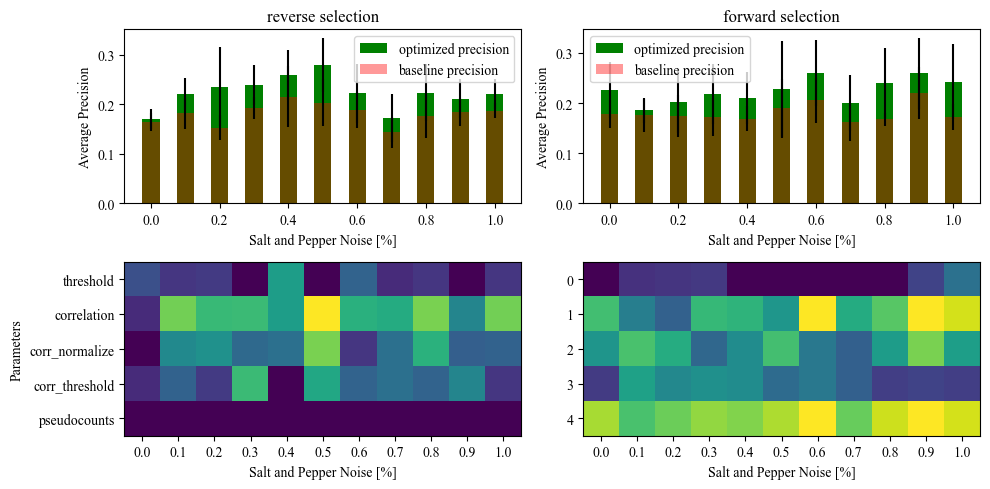

In [15]:
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.family"] = "Times New Roman"
labels = ["threshold",
    #"percentile",
    "correlation",
    "corr_normalize",
    "corr_threshold",
    #"corr_threshold_percentile",
    "pseudocounts"]
plt.subplot(2,2,1)
plt.bar(np.arange(0,max,step),np.mean(rev_results[:,0], axis=1),
    yerr=np.std(rev_results[:,0], axis=1),
    color="g",
    label = "optimized precision", width=0.05)
plt.bar(np.arange(0,max,step),np.mean(rev_results[:,1], axis=1),
    yerr=np.std(rev_results[:,1], axis=1),
    color="r",
    label = "baseline precision", alpha=0.4, width=0.05)
plt.title(f"reverse selection")
plt.legend()
plt.xlabel("Salt and Pepper Noise [%]")
plt.ylabel("Average Precision")
plt.subplot(2,2,2)
plt.bar(np.arange(0,max,step),np.mean(for_results[:,0], axis=1),
    yerr=np.std(for_results[:,0], axis=1),
    color="g",
    label = "optimized precision", width=0.05)
plt.bar(np.arange(0,max,step),np.mean(for_results[:,1], axis=1),
    yerr=np.std(for_results[:,1], axis=1),
    color="r",
    label = "baseline precision", alpha=0.4, width=0.05)
plt.title(f"forward selection")
plt.legend()
plt.xlabel("Salt and Pepper Noise [%]")
plt.ylabel("Average Precision")

plt.subplot(2,2,3)

#[rev_results[]for n in range(rev_results.shape[-1])]

rev_precision = np.mean(rev_results[:,0], axis=1)
rev_results_mean = np.mean(rev_results[:,2:], 2)
rev_weighted_results =rev_results_mean* rev_precision.repeat(rev_results_mean.shape[1]).reshape(rev_results_mean.shape)

plt.imshow(rev_weighted_results.T, aspect="auto", interpolation="nearest")
ticks, _ = plt.yticks()

plt.yticks(ticks[1:-1], labels)
plt.xticks(ticks = np.arange(0,11, 1).astype(int),labels = np.arange(0, max, step).round(2))
plt.xlabel("Salt and Pepper Noise [%]")
plt.ylabel("Parameters")
plt.subplot(2,2,4)

for_precision = np.mean(for_results[:,0], axis=1)
for_results_mean = np.mean(for_results[:,2:], 2)

for_weighted_results =for_results_mean* for_precision.repeat(for_results_mean.shape[1]).reshape(for_results_mean.shape)

plt.imshow(for_weighted_results.T, aspect="auto", interpolation="nearest")
plt.xticks(ticks = np.arange(0,11, 1).astype(int),labels = np.arange(0, max, step).round(2))
plt.xlabel("Salt and Pepper Noise [%]")
plt.tight_layout()
plt.rcParams["figure.figsize"] = (5, 5)

if save:
    print("Saving!")
    plt.savefig("./presentation/masksel_params_tableau.pdf")

In [8]:
# increase noise on the region matrices
repeats = 3
step = 0.1
max = 1
max += step
n_comp= 33
cum = False
rev =True
for_parameters = {str(n):False for n in range(n_comp)}
rev_parameters = {str(n):True for n in range(n_comp)}
svd_solver = "arpack"
rev_results_pca = np.empty((int(max/step), n_comp+2, repeats))
for_results_pca = np.empty((int(max/step), n_comp+2, repeats))
for r in range(repeats):
    print(f"Repeat: {r}")
    for n, p in enumerate(np.arange(0,max, step)):
        print(f"Noise: {p}")
        config.update({"noise_p":p})

        if cum or rev:
            data, mask, full_rna, gt_interv, sim_regime, beta = generate_data(
            **config)
            grn = data.pop("geff")
        
            base_prec = get_precision(grn, selection_wrap_pca(**data, **rev_parameters))
            print(f"Baseline Precision: {base_prec}")
            
            PCs, max_prec= rev_select(
                data.copy(),
                _parameters = rev_parameters.copy(),
                _baseline_prec=0.01,
                mask_func=selection_wrap_pca,
                eval=lambda x: get_precision(grn=grn, beta=x),)
            print(f"Optimized Precision: {max_prec}")


            rev_results_pca[n,:, r] = np.append([max_prec, base_prec],
                list(PCs.values()))

        data, mask, full_rna, gt_interv, sim_regime, beta = generate_data(
            **config)
        grn = data.pop("geff")
        
        base_prec = get_precision(grn, selection_wrap_pca(**data, **for_parameters))
        print(f"Baseline Precision: {base_prec}")
        
        PCs, max_prec= for_select(
            data.copy(),
            _parameters = for_parameters.copy(),
            _baseline_prec=0.01,
            mask_func=selection_wrap_pca,
            eval=lambda x: get_precision(grn=grn, beta=x),)
        print(f"Optimized Precision: {max_prec}")

        
        for_results_pca[n,:, r] = np.append([max_prec, base_prec],
            list(PCs.values()))

Repeat: 0
Noise: 0.0
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.0
average precision vs geff:  0.2523021885521885
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.25659611992945325
Trimming RNA.
Baseline Precision: 0.1604040404040404
Optimized Precision: 0.1604040404040404
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.0
average precision vs geff:  0.2346176046176046
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.24354497354497356
Trimming RNA.
Baseline Precision: 0.1900865800865801
Optimized Precision: 0.1900865800865801
Noise: 0.1
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.1
average precision vs geff:  0.16415420346286552
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.19502326744577447
Trimming RNA.
Baseline Precision: 0.19956709956709956
Optimized Precision: 0.19956709956709956
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.1
average precision vs geff:  0.21456476169088023
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.2177443726352929
Trimming RNA.
Baseline Precision: 0.16363636363636364
Optimized Precision: 0.16363636363636364
Noise: 0.2
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.2
average precision vs geff:  0.12288487547640681
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.181692099860397
Trimming RNA.
Baseline Precision: 0.11818181818181818
Optimized Precision: 0.11818181818181818
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.2
average precision vs geff:  0.1710450318215922
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.18351726390544196
Trimming RNA.
Baseline Precision: 0.1497159090909091
Optimized Precision: 0.1497159090909091
Noise: 0.30000000000000004
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.30000000000000004
average precision vs geff:  0.18825494809243137
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.2356526625613105
Trimming RNA.
Baseline Precision: 0.19136363636363637
Optimized Precision: 0.19136363636363637
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.30000000000000004
average precision vs geff:  0.2597835158600403
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.2615330119547745
Trimming RNA.
Baseline Precision: 0.16363636363636364
Optimized Precision: 0.16363636363636364
Noise: 0.4
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.4
average precision vs geff:  0.21767821839871027
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.2355816999621968
Trimming RNA.
Baseline Precision: 0.2
Optimized Precision: 0.2
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.4
average precision vs geff:  0.19332198826336566
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.21181364609729608
Trimming RNA.
Baseline Precision: 0.22978181818181817
Optimized Precision: 0.22978181818181817
Noise: 0.5
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.5
average precision vs geff:  0.17874085444844406
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.1792417107244098
Trimming RNA.
Baseline Precision: 0.14545454545454545
Optimized Precision: 0.14545454545454545
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.5
average precision vs geff:  0.1660705275053752
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.18828306091960553
Trimming RNA.
Baseline Precision: 0.14545454545454545
Optimized Precision: 0.14545454545454545
Noise: 0.6000000000000001
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.6000000000000001
average precision vs geff:  0.12129141487702097
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.13202115420455965
Trimming RNA.
Baseline Precision: 0.14545454545454545
Optimized Precision: 0.14545454545454545
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.6000000000000001
average precision vs geff:  0.19632274932613464
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.19895680243372182
Trimming RNA.
Baseline Precision: 0.1
Optimized Precision: 0.1
Noise: 0.7000000000000001
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.7000000000000001
average precision vs geff:  0.22648295474981378
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.252414861893353
Trimming RNA.
Baseline Precision: 0.15454545454545454
Optimized Precision: 0.15454545454545454
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.7000000000000001
average precision vs geff:  0.1772413135973595
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.18915481101538487
Trimming RNA.
Baseline Precision: 0.2
Optimized Precision: 0.2
Noise: 0.8
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.8
average precision vs geff:  0.16082861465234483
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.18055115949389494
Trimming RNA.
Baseline Precision: 0.17272727272727273
Optimized Precision: 0.17272727272727273
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.8
average precision vs geff:  0.16359456117313395
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.1739155452746997
Trimming RNA.
Baseline Precision: 0.12727272727272726
Optimized Precision: 0.12727272727272726
Noise: 0.9
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.9
average precision vs geff:  0.2119971789506742
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.22557968491520386
Trimming RNA.
Baseline Precision: 0.16363636363636364
Optimized Precision: 0.16363636363636364
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.9
average precision vs geff:  0.30503981501908733
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.3105739841339351
Trimming RNA.
Baseline Precision: 0.14545454545454545
Optimized Precision: 0.14545454545454545
Noise: 1.0
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 1.0
average precision vs geff:  0.2170999264620198
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.21840347728099185
Trimming RNA.
Baseline Precision: 0.15454545454545454
Optimized Precision: 0.15454545454545454
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 1.0
average precision vs geff:  0.17293600744225582
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.18290354760487834
Trimming RNA.
Baseline Precision: 0.14545454545454545
Optimized Precision: 0.14545454545454545
Repeat: 1
Noise: 0.0
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.0
average precision vs geff:  0.25608877233877236
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.2657051282051282
Trimming RNA.
Baseline Precision: 0.2225174825174825
Optimized Precision: 0.2225174825174825
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.0
average precision vs geff:  0.2897853535353535
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.29780919312169307
Trimming RNA.
Baseline Precision: 0.22950757575757577
Optimized Precision: 0.22950757575757577
Noise: 0.1
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.02 mins
0
Normalizing data
Normalizing data
Adding noise: 0.1
average precision vs geff:  0.2837656769486834
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.2855599286222204
Trimming RNA.
Baseline Precision: 0.19090909090909092
Optimized Precision: 0.19090909090909092
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.1
average precision vs geff:  0.26924866312561163
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.272710612621035
Trimming RNA.
Baseline Precision: 0.19956709956709956
Optimized Precision: 0.19956709956709956
Noise: 0.2
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.2
average precision vs geff:  0.2144123698349256
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.21532146074401648
Trimming RNA.
Baseline Precision: 0.15429292929292932
Optimized Precision: 0.15429292929292932
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.2
average precision vs geff:  0.1641874008185672
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.19925857712332795
Trimming RNA.
Baseline Precision: 0.18155844155844156
Optimized Precision: 0.18155844155844156
Noise: 0.30000000000000004
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.02 mins
0
Normalizing data
Normalizing data
Adding noise: 0.30000000000000004
average precision vs geff:  0.18704605273828115
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.1879551436473721
Trimming RNA.
Baseline Precision: 0.17028708133971293
Optimized Precision: 0.17028708133971293
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.02 mins
0
Normalizing data
Normalizing data
Adding noise: 0.30000000000000004
average precision vs geff:  0.18360896549092287
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.20647575002859608
Trimming RNA.
Baseline Precision: 0.20909090909090908
Optimized Precision: 0.20909090909090908
Noise: 0.4
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.4
average precision vs geff:  0.21938114165936892
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.2284429740129428
Trimming RNA.
Baseline Precision: 0.19090909090909092
Optimized Precision: 0.19090909090909092
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.4
average precision vs geff:  0.11274344912592511
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.1417079561478708
Trimming RNA.
Baseline Precision: 0.1
Optimized Precision: 0.1
Noise: 0.5
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.5
average precision vs geff:  0.1872383516281885
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.21706056347107053
Trimming RNA.
Baseline Precision: 0.18181818181818182
Optimized Precision: 0.18181818181818182
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.5
average precision vs geff:  0.15088651319612656
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.1517712605997527
Trimming RNA.
Baseline Precision: 0.13636363636363635
Optimized Precision: 0.13636363636363635
Noise: 0.6000000000000001
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.6000000000000001
average precision vs geff:  0.23915515707237356
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.24278558598696015
Trimming RNA.
Baseline Precision: 0.16363636363636364
Optimized Precision: 0.16363636363636364
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.6000000000000001
average precision vs geff:  0.1880293562836946
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.19319188835265266
Trimming RNA.
Baseline Precision: 0.13636363636363635
Optimized Precision: 0.13636363636363635
Noise: 0.7000000000000001
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.7000000000000001
average precision vs geff:  0.2178444538077741
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.2221195449113711
Trimming RNA.
Baseline Precision: 0.18181818181818182
Optimized Precision: 0.18181818181818182
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.7000000000000001
average precision vs geff:  0.17140150743345645
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.1756874330673885
Trimming RNA.
Baseline Precision: 0.17272727272727273
Optimized Precision: 0.17272727272727273
Noise: 0.8
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.8
average precision vs geff:  0.11698648939240644
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.11732251089778278
Trimming RNA.
Baseline Precision: 0.09090909090909091
Optimized Precision: 0.09090909090909091
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.8
average precision vs geff:  0.18809794925289292
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.19447506906776393
Trimming RNA.
Baseline Precision: 0.16363636363636364
Optimized Precision: 0.16363636363636364
Noise: 0.9
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.9
average precision vs geff:  0.26229147562834015
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.2724578942012963
Trimming RNA.
Baseline Precision: 0.12727272727272726
Optimized Precision: 0.12727272727272726
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.9
average precision vs geff:  0.16237356378519496
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.1775782368243065
Trimming RNA.
Baseline Precision: 0.17272727272727273
Optimized Precision: 0.17272727272727273
Noise: 1.0
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 1.0
average precision vs geff:  0.26446015041859544
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.2741124908707982
Trimming RNA.
Baseline Precision: 0.16363636363636364
Optimized Precision: 0.16363636363636364
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 1.0
average precision vs geff:  0.26141970803107867
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.27075404309699314
Trimming RNA.
Baseline Precision: 0.16363636363636364
Optimized Precision: 0.16363636363636364
Repeat: 2
Noise: 0.0
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.0
average precision vs geff:  0.17739015151515153
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.18802380952380954
Trimming RNA.
Baseline Precision: 0.1801818181818182
Optimized Precision: 0.1801818181818182
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.0
average precision vs geff:  0.16118939393939394
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.16997222222222222
Trimming RNA.
Baseline Precision: 0.1895909090909091
Optimized Precision: 0.1895909090909091
Noise: 0.1
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.1
average precision vs geff:  0.2667106576778614
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.2894730648736361
Trimming RNA.
Baseline Precision: 0.23073426573426575
Optimized Precision: 0.23073426573426575
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.1
average precision vs geff:  0.18657974050813936
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.19703493034900418
Trimming RNA.
Baseline Precision: 0.14545454545454545
Optimized Precision: 0.14545454545454545
Noise: 0.2
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.2
average precision vs geff:  0.22281654800381062
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.22951397918138322
Trimming RNA.
Baseline Precision: 0.1497159090909091
Optimized Precision: 0.1497159090909091
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.2
average precision vs geff:  0.17903585870459438
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.1808174444519084
Trimming RNA.
Baseline Precision: 0.16200956937799044
Optimized Precision: 0.16200956937799044
Noise: 0.30000000000000004
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.30000000000000004
average precision vs geff:  0.19047488827306014
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.2002005683616977
Trimming RNA.
Baseline Precision: 0.17272727272727273
Optimized Precision: 0.17272727272727273
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.30000000000000004
average precision vs geff:  0.1665861725801625
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.18528132981530376
Trimming RNA.
Baseline Precision: 0.15967914438502676
Optimized Precision: 0.15967914438502676
Noise: 0.4
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.4
average precision vs geff:  0.17974037281607125
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.18636656724416042
Trimming RNA.
Baseline Precision: 0.2
Optimized Precision: 0.2
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.4
average precision vs geff:  0.216056632004997
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.22640413003048615
Trimming RNA.
Baseline Precision: 0.15454545454545454
Optimized Precision: 0.15454545454545454
Noise: 0.5
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.5
average precision vs geff:  0.2004946903423815
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.21060546658407076
Trimming RNA.
Baseline Precision: 0.17272727272727273
Optimized Precision: 0.17272727272727273
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.5
average precision vs geff:  0.14650435462047318
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.15022407582602051
Trimming RNA.
Baseline Precision: 0.12727272727272726
Optimized Precision: 0.12727272727272726
Noise: 0.6000000000000001
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.6000000000000001
average precision vs geff:  0.13816794820229567
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.15052912320600048
Trimming RNA.
Baseline Precision: 0.12727272727272726
Optimized Precision: 0.12727272727272726
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.6000000000000001
average precision vs geff:  0.13684530317050575
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.17012875256811388
Trimming RNA.
Baseline Precision: 0.15454545454545454
Optimized Precision: 0.15454545454545454
Noise: 0.7000000000000001
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.7000000000000001
average precision vs geff:  0.19687685632432145
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.2026599540682441
Trimming RNA.
Baseline Precision: 0.18181818181818182
Optimized Precision: 0.18181818181818182
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.7000000000000001
average precision vs geff:  0.226911251822072
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.23917590913513426
Trimming RNA.
Baseline Precision: 0.15454545454545454
Optimized Precision: 0.15454545454545454
Noise: 0.8
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.8
average precision vs geff:  0.19843968720603752
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.22898276871000076
Trimming RNA.
Baseline Precision: 0.13636363636363635
Optimized Precision: 0.13636363636363635
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.8
average precision vs geff:  0.15845297112724083
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.1708951508067884
Trimming RNA.
Baseline Precision: 0.15454545454545454
Optimized Precision: 0.15454545454545454
Noise: 0.9
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 0.9
average precision vs geff:  0.24875702650423676
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.2811073036194949
Trimming RNA.
Baseline Precision: 0.20909090909090908
Optimized Precision: 0.20909090909090908
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.02 mins
0
Normalizing data
Normalizing data
Adding noise: 0.9
average precision vs geff:  0.2701845909520022
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.291720586392609
Trimming RNA.
Baseline Precision: 0.19090909090909092
Optimized Precision: 0.19090909090909092
Noise: 1.0
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 1.0
average precision vs geff:  0.19228107332319358
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.21165845675596115
Trimming RNA.
Baseline Precision: 0.13636363636363635
Optimized Precision: 0.13636363636363635
Generating the GRN...



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Time spent: 0.01 mins
0
Normalizing data
Normalizing data
Adding noise: 1.0
average precision vs geff:  0.22371391809271857
mask is bigger than grn! Check if RNA trimming was performed.
average precision vs beta:  0.25214299456494654
Trimming RNA.
Baseline Precision: 0.18181818181818182
Optimized Precision: 0.18181818181818182


Saving!


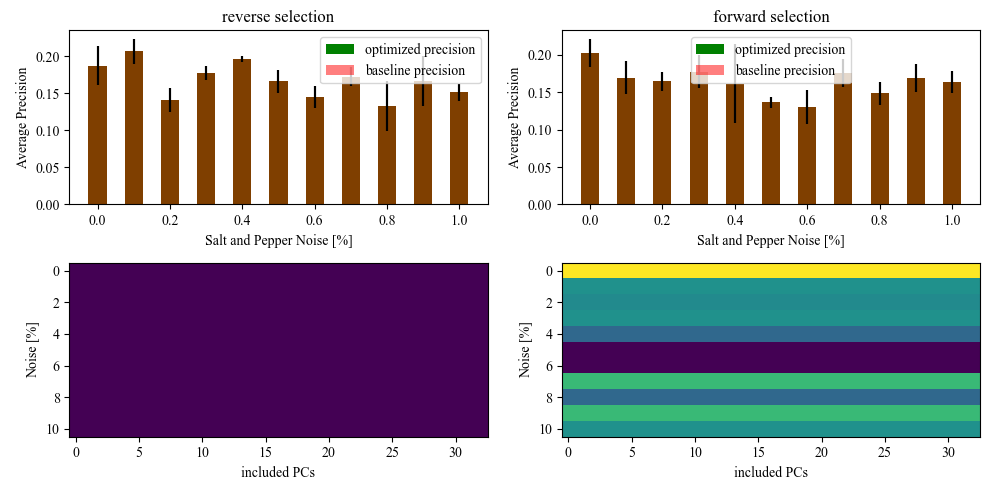

In [9]:
plt.rcParams["figure.figsize"] = (10, 5)
labels = np.arange(n_comp)
plt.subplot(2,2,1)
plt.bar(np.arange(0,max,step),np.mean(rev_results_pca[:,0], axis=1),
    yerr = np.std(rev_results_pca[:,0], axis=1), width=0.05,
    color="g", label = "optimized precision")
plt.bar(np.arange(0,max,step),np.mean(rev_results_pca[:,1], axis=1),
    yerr = np.std(rev_results_pca[:,1], axis=1), width=0.05,
    alpha=0.5, color="r", label = "baseline precision")
#plt.bar(np.arange(0,max,step),np.sum(np.median(rev_results_pca[:,2:], axis=2), axis=1) / 330, color="b", label= "PC count",alpha=0.1)
plt.title(f"reverse selection")
plt.legend()
plt.xlabel("Salt and Pepper Noise [%]")
plt.ylabel("Average Precision")
plt.subplot(2,2,2)
plt.bar(np.arange(0,max,step),np.mean(for_results_pca[:,0], axis=1),
    yerr = np.std(for_results_pca[:,0], axis=1), width=0.05,
    color="g", label = "optimized precision")
plt.bar(np.arange(0,max,step),np.mean(for_results_pca[:,1], axis=1),
    yerr = np.std(for_results_pca[:,1], axis=1), width=0.05,
    alpha=0.5, color="r", label = "baseline precision")
plt.title(f"forward selection")
plt.legend()
plt.xlabel("Salt and Pepper Noise [%]")
plt.ylabel("Average Precision")

plt.subplot(2,2,3)

rev_precision = np.median(rev_results_pca[:,0], axis=1)
rev_results_pca_median = np.median(rev_results_pca[:,2:], axis=2)
rev_weighted_results =rev_results_pca_median* rev_precision.repeat(rev_results_pca_median.shape[1]).reshape(rev_results_pca_median.shape)

plt.imshow(rev_weighted_results, aspect="auto", interpolation="nearest")
plt.xlabel("included PCs")
plt.ylabel("\nNoise [%]")
ticks, _ = plt.yticks()

#plt.yticks(ticks[1:-1], labels)

plt.subplot(2,2,4)

for_precision = np.median(for_results_pca[:,0], axis=1)
for_results_pca_median = np.median(for_results_pca[:,2:], axis=2)

for_weighted_results =for_results_pca_median* for_precision.repeat(for_results_pca_median.shape[1]).reshape(for_results_pca_median.shape)

plt.imshow(for_weighted_results, aspect="auto", interpolation="nearest")
plt.xlabel("included PCs")
plt.ylabel("\nNoise [%]")
plt.tight_layout()
if save:
    print("Saving!")
    plt.savefig("./presentation/masksel_pcs_tableau.pdf")

In [10]:
# increase noise on the region matrices
repeats = 1
step = 0.25
max = 1.1
rev_results = np.empty((len(rev_parameters.values()), repeats))
for_results = np.empty((len(for_parameters.values()), repeats))
rev_results = np.empty((int(max/step), n_comp+2, repeats))
for_results = np.empty((int(max/step), n_comp+2, repeats))
for r in range(repeats):
    print(f"Repeat: {r}")
    for n, p in enumerate(np.arange(0,max, step)):
        config.update({"noise_p":p})
        base_prec = output_precision(selection_wrap_pca(**config, **rev_parameters))
        params, max_prec= rev_select(data=config,
                                     _parameters=rev_parameters.copy(),
                                     eval=output_precision,
                                     mask_func=selection_wrap_pca)        
        rev_results[n, :, r] = np.append([max_prec, base_prec], list(params.values()))

        config.update({"noise_p":p})
        base_prec = output_precision(selection_wrap_pca(**config, **for_parameters))
        params, max_prec= for_select(data=config,
                                     _parameters=for_parameters.copy(),
                                     eval=output_precision,
                                     mask_func=selection_wrap_pca)
        for_results[n, :, r] = np.append([max_prec, base_prec], list(params.values()))


Repeat: 0


KeyError: 'atac'